In [1]:
import rasterio
import matplotlib.pyplot as plt
import hndlRas
import mbUtils
import warpRas
import geopandas as gpd
import glob
import pandas as pd
import numpy as np
import os
%matplotlib inline

In [2]:
# download raster files from google drive based on the blob id
# make sure that this folder's permissions are public (see hndlRas.py)
# define starting and ending slice of string indices representing
# the date in YYYYMMDD format

# if files are already downloaded from previous runs
if len(glob.glob('*.tif')) > 1:
    files = hndlRas.readTif(stSlice = 0, enSlice = 8)
    
# if need to download
else:
    files = hndlRas.arrTif('1Tdq2LA4UV5S5HTL8oBzhoRry1V1wK6nk',stSlice = 0,\
                    enSlice = 8)
# visualize output file structure and corresponding dates
files

,fname,time
0,20090604_1939_1020010008A18900_1020010008C45D0...,2009-06-04
1,20140823_1932_10200100324CCF00_10200100341F530...,2014-08-23
2,20150818_1939_104001000F1D3000_1040010010D7CB0...,2015-08-18
3,20130603_1915_10200100236DC700_1020010021A8860...,2013-06-03
4,20111027_1926_1050410002BB0C00_1050410002BDA50...,2011-10-27
5,20160507_2209_102001004F892100_10200100503E1A0...,2016-05-07
6,20080926_1926_1020010004796700_1020010004B32D0...,2008-09-26
7,20120901_1921_10504100007F0300_105041000077540...,2012-09-01
8,20150309_2026_1020010038BBD000_102001003AD5FD0...,2015-03-09


In [3]:
# define array indicating rasters of interest
# use files pandas dataframe indices!
z = [6,7,1,2]

In [4]:
# load in vegetation classes
landClass = rasterio.open('ASO/SubEme_8m_veg_cropped.tif')
# load in lidar data
ASOSoff = rasterio.open('ASO/SubEme_8m_topo_cropped.tif')

[Text(0.5, 1.0, 'ASO snow-free elevation')]

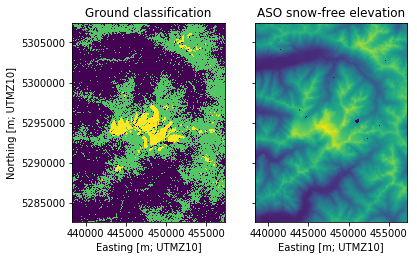

In [5]:
# plot vegetation classes
extent = [landClass .bounds.left, landClass .bounds.right, \
          landClass .bounds.bottom, landClass .bounds.top]

plt.figure()
ax1 = plt.subplot(1,2,1)
ax1.imshow(landClass.read(1),extent = extent)
ax1.set(ylabel='Northing [m; UTMZ10]',\
       xlabel='Easting [m; UTMZ10]')
ax1.set(title='Ground classification')
ax2 = plt.subplot(1,2,2)
ax2.imshow(ASOSoff.read(1),extent = extent)
ax2.set(xlabel='Easting [m; UTMZ10]')
ax2.tick_params(labelleft=False)
ax2.set(title='ASO snow-free elevation')

#plt.savefig('ASOdatasets.png')

In [6]:
# this is temporary until I figure out a better way
# probably using xarray??
datacube = np.random.randn(3090,2365,len(z))

dem1 = None
cnt = 0
ASOoff = rasterio.open('ASO/SubEme_8m_topo_cropped.tif').read(1)
ASOoff[ASOoff <= 0] = np.nan

# for each dem
for i in z:
#for i in range(0,1):
    warpRas.warpDEMs('ASO/SubEme_8m_topo_cropped.tif',\
                     files['fname'][i],'newz1.tif')
    
    # open warped DEMs
    #dem1 = rasterio.open('newz1.tif')
    dem1 = rasterio.open('newz1.tif').read(1)
    dem1[dem1 <= 0] = np.nan
    
    #plt.figure()
    #plt.imshow(dem1)
    
    # populate datecube with DEM differences
    datacube[:,:,cnt] = dem1 - ASOoff
    cnt += 1
    
    dem1 = None
    os.remove('newz1.tif')
    

In [7]:
# data stack for standard deviation in each class
stdStack = np.std(datacube,axis=2)
glacStack = np.copy(stdStack)
glacStack[landClass.read(1) != 20] = np.nan
forStack = np.copy(stdStack)
forStack[landClass.read(1) != 1] = np.nan
clrStack = np.copy(stdStack)
clrStack[landClass.read(1) != 15] = np.nan

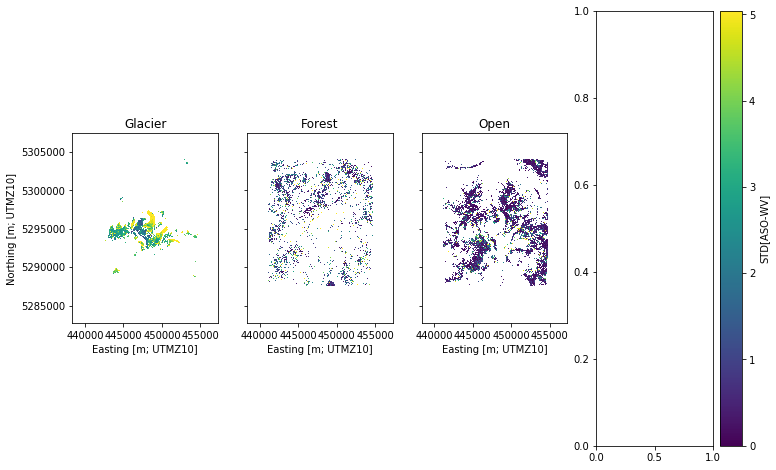

In [8]:
# plot STD in all vegetation classes
vmaxer = np.nanpercentile(stdStack,95)

f = plt.figure()
ax1 = plt.subplot(1,4,1)
ax1.imshow(glacStack,extent = extent,vmin=0,vmax=vmaxer)
ax1.set(ylabel='Northing [m; UTMZ10]',\
       xlabel='Easting [m; UTMZ10]')
ax1.set(title='Glacier')
ax2 = plt.subplot(1,4,2)
ax2.imshow(forStack,extent = extent,vmin=0,vmax=vmaxer)
ax2.set(xlabel='Easting [m; UTMZ10]')
ax2.tick_params(labelleft=False)
ax2.set(title='Forest')
ax3 = plt.subplot(1,4,3)
mpbl = ax3.imshow(clrStack,extent = extent,vmin=0,vmax=vmaxer)
ax3.set(xlabel='Easting [m; UTMZ10]')
ax3.tick_params(labelleft=False)
ax3.set(title='Open')
ax4 = plt.subplot(1,4,4)
cbar = f.colorbar(mpbl,)
f.set_size_inches(12,8)
cbar.ax.set_ylabel('STD[ASO-WV]', rotation=90)

plt.savefig('spatialSTD.png')

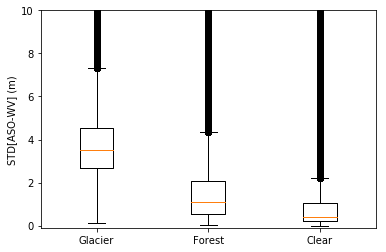

In [9]:
# boxplots for corresponding classes
collection = [glacStack[~np.isnan(glacStack)],\
              forStack[~np.isnan(forStack)],\
              clrStack[~np.isnan(clrStack)]]

plt.boxplot(collection)
plt.ylim(-0.1,10)
plt.xticks([1,2,3],['Glacier','Forest','Clear'])
plt.ylabel('STD[ASO-WV] (m)')

plt.savefig('boxplotSTD.png')